#Generic Wastewater Model Testing

##Intro

This is a testing ground for wastewater pipeline containing several modules. Due to unknown dependancies between features as well as correlations we may not be aware of yet, it would be prudent to generate a random dataset and set up a skeleton framework that manipulates the data and runs it through a ML model. These simulations will form the basis of our understanding of how a real pipeline in a plant will look like as well as serve as a convenient tester should we ever get a hold of real sensor data. 

**NOTE** *This pipeline uses randomly generated data so metrics and accuracies will have no applicable meaning. This notebook is simply to test and set up several models that can be readily tested on sensor data when it does arrive for more thorough optimization.*

In [0]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

The initial exercise is a supervised learning regression problem. All features are numeric.
Given an initial input of wastewater data and its output of biomass and exiting flow rate of purified water, our model will be trained and be able to predict the biomass/exit FR of any given instance of these observables.
It should be noted that there are 2 flowrates, the initial speed of wastewater as it enters and is recorded by the sensor and the flow rate of the purified water going out.

We want to maximize exit flow rate (the more purified water produced the better) and biomass (to be converted into more energy by a converter).

In [0]:
var = ['biomass (g/L)', 'input_wastewater_flow_rate (L/sec)', 'output_purified_flow_rate', 'temperature (C)', 'pH', 'salinity(mg/L)', 'turbidity (Nephelometric Turbidity Units / NTU)', 'chemical_oxygen_demand/COD (mg/L)', 'total_suspended_solids/TSS (mg/L)' , 'total_dissolved_solids/TDS (mg/L)' , 'heavy_metals (mg/L)' , 'napthenic_acids/NAs (mg/L)']
dict = {}
for i in var:
  dict[i] = random.sample(range(0, 200000), 50)
df = pd.DataFrame(dict)
df

,biomass (g/L),chemical_oxygen_demand/COD (mg/L),heavy_metals (mg/L),input_wastewater_flow_rate (L/sec),napthenic_acids/NAs (mg/L),output_purified_flow_rate,pH,salinity(mg/L),temperature (C),total_dissolved_solids/TDS (mg/L),total_suspended_solids/TSS (mg/L),turbidity (Nephelometric Turbidity Units / NTU)
0,55059,64028,84897,107097,525,192456,9828,87771,136998,160219,106626,17652
1,156022,114236,154931,15900,77317,180049,90559,196200,99399,146047,197524,147385
2,27114,118976,189701,89192,188078,115109,165546,27163,5586,108188,126497,176620
3,17012,5566,22777,187351,194336,31468,129173,52854,55377,165953,54215,144320
4,193518,17883,57190,76453,66876,40986,28124,80626,97541,191624,18724,98124
5,86332,179989,22536,136061,3900,25728,59785,45647,64073,3379,33930,20428
6,132382,52556,126542,131768,52347,9560,177809,80172,46270,138907,69186,164614
7,177273,199544,156072,8677,149843,125715,51757,179558,14523,29132,6879,155688
8,104351,149633,96442,21652,53883,89625,151559,6278,673,109455,170087,184658
9,75791,13478,99186,110479,50562,197605,163767,18110,159837,95826,1415,142412


In [0]:
train_df = df.sample(frac=0.8,random_state=0) 
test_df = df.drop(train_df.index)
train_labels = train_df.pop('biomass (g/L)')
test_labels = test_df.pop('biomass (g/L)')

Seen above this is our test dataset that we will be playing with. As mentioned before these values are purely random placeholders (a pH level of 9828 is literally impossible) and their real-life implications are to be ignored.
Also above are our training and test datasets with a 80/20 split. We separate the biomass feature from the data set as this is what we want our model to predict

In [0]:
input_df = df.drop(['biomass (g/L)', 'flow_rate (L/sec)'], axis =1 )
output_df = df[['biomass (g/L)', 'flow_rate (L/sec)']]

,chemical_oxygen_demand/COD (mg/L),heavy_metals (mg/L),napthenic_acids/NAs (mg/L),pH,salinity(mg/L),temperature (C),total_dissolved_solids/TDS (mg/L),total_suspended_solids/TSS (mg/L),turbidity (Nephelometric Turbidity Units / NTU)
0,15439,60194,135456,167852,17451,44656,198004,66151,124983
1,155124,14031,70916,192579,138443,76170,178358,147291,103983
2,96836,184633,103768,109956,150436,2412,67402,46863,59950
3,67406,31650,154563,130500,39469,73918,75127,10727,198975
4,177762,42770,166855,146346,90581,143130,140916,87091,194772
5,43643,114498,186984,192078,93942,132208,114179,39061,92818
6,65333,156153,59126,182057,191044,18556,102057,91985,115161
7,15793,111280,86006,133537,68777,124026,38280,51632,57003
8,149899,141604,92629,182258,160144,52015,193920,64594,29714
9,76739,74629,90789,33341,81312,15096,96693,190583,102622


In [0]:
'''
def train_input_fn(df):
  features = df.drop(['biomass (g/L)'], axis =1 )
  labels = df[['biomass (g/L)']]
  return features, labels
'''



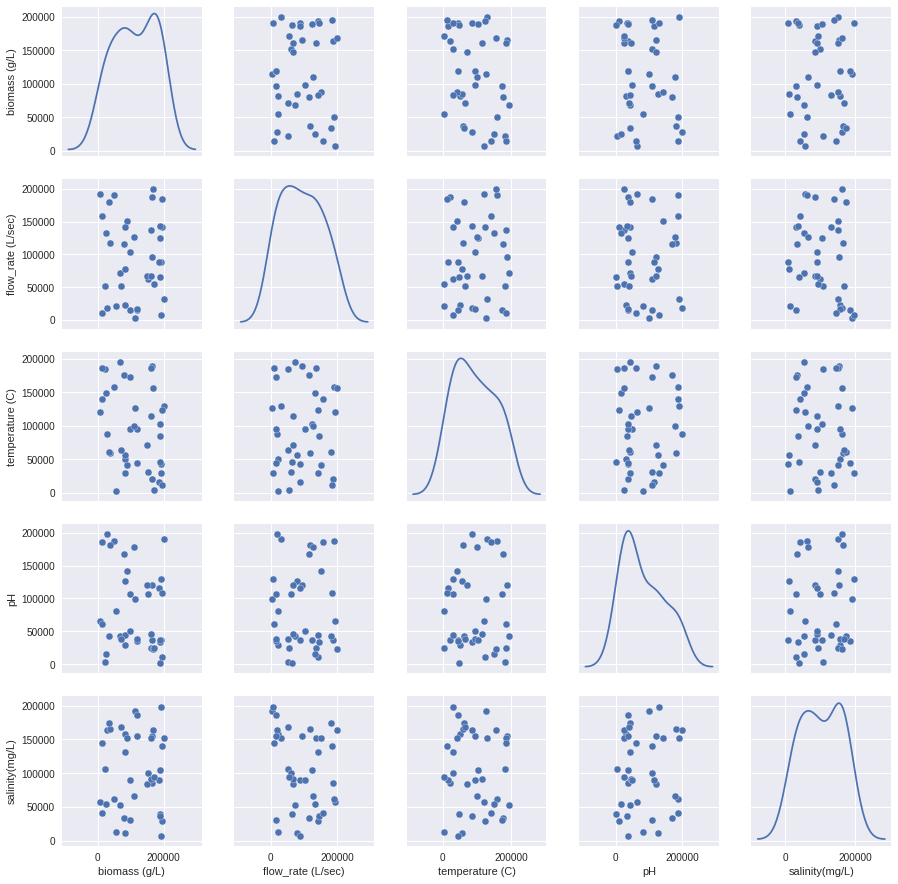

In [0]:
sns.pairplot(train_df[['biomass (g/L)', 'flow_rate (L/sec)', 'temperature (C)', 'pH', 'salinity(mg/L)']], diag_kind="kde")

In [0]:
train_stats = train_df.describe()
train_stats.pop("biomass (g/L)")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
chemical_oxygen_demand/COD (mg/L),40.0,106054.825,57002.172460,601.0,56987.25,127196.5,147260.75,188998.0
flow_rate (L/sec),40.0,93252.850,61095.359265,2520.0,46574.50,88363.0,141301.00,199071.0
heavy_metals (mg/L),40.0,108601.700,55919.693687,8072.0,64830.00,105556.0,153603.00,197524.0
napthenic_acids/NAs (mg/L),40.0,102513.700,54103.116152,1708.0,57297.00,99719.0,149795.25,196126.0
pH,40.0,82223.200,61135.499933,1498.0,35827.25,55209.0,122648.50,197899.0
salinity(mg/L),40.0,103411.725,57453.685039,7717.0,54183.00,96943.0,155006.50,198367.0
temperature (C),40.0,93857.025,59634.346870,2938.0,44508.00,90973.5,142605.25,195357.0
total_dissolved_solids/TDS (mg/L),40.0,118934.500,61284.922050,6325.0,79039.25,131644.5,167609.75,199239.0
total_suspended_solids/TSS (mg/L),40.0,125052.100,56300.989374,13300.0,74430.50,130815.5,169766.00,199094.0
turbidity (Nephelometric Turbidity Units / NTU),40.0,101243.050,52250.369761,8459.0,63441.75,97282.0,144549.50,190024.0
